<h1>Ising Model 2D Prediction of Phases Using Machine Learning</h1>

<p>This is a notebook created for the Machine Learning option in Autumn 2019 Semestre in CY Université. The data was shared in the course folder. </p>

<p>We will consider the Ising Model in 2D with the following properties and parameters and we will try to create models to predict the configuration phases: 
    <ul>
        <li>40x40 Square Lattice</li>
        <li>Ising Interaction $$J = -1.0$$</li>
        <li>Temperature is equally partitioned in the following interval $$ T \in \{0.25, 0.50, \dots 4.0\}$$</li>
        <li>The assigned labels are: 0 if disordered, 1 if ordered</li>
        <li>We will also have a critical region. Onsager's result is $$T_C \approx 2.26$$ Then we expect three types of states: $$T<2.0, \text{ordered}$$
                 $$2.0<T<2.5, \text{critical region}$$
                 $$T>2.5 \text{disordered}$$</li>
    </ul>
</p>

<h2>Loading the Data</h2>

<p>We will first start by importing necessary packages. We will use Keras/TensorFlow for our training. Pickle for loading the data and matplotlib for visualizations.</p>

In [1]:
import pickle as pk
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras import models 
from keras.models import Model

from keras import layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.utils import to_categorical 
from keras.optimizers import RMSprop, Adam
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import image

from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle


Using TensorFlow backend.


<p>Now we can create the files with the data and the labels of our dataset. We read it using pickle.</p>

In [2]:
# We start by correctly inputing the file names of the data
file_name_data = "Ising2DFM_reSample_L40_T=All.pkl"
file_name_labels = "Ising2DFM_reSample_L40_T=All_labels.pkl"

# We open the files
file_data = open(file_name_data, "rb") # rb stands for "read, binary"
file_labels = open(file_name_labels, "rb")

# We load the data from the files
data = pk.load(file_data)
labels = pk.load(file_labels)

# Data is here packed uint8 elements meaning that it needs unpacking.
# We can think of it as decompressing a compressed file. 
data = np.unpackbits(data).reshape(-1,1600)
data = data.astype("int") # Making sure the type is integer

<p>Let us see how the data looks like.</p>

In [3]:
print("Data is as follows: \n")
print(data)
print("The shape of the data: ")
print(data.shape)


print("\n")
print("Labels are as follows: \n")
print(labels)
print("The shape of labels")
print(labels.shape)

Data is as follows: 

[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 1 0 0]]
The shape of the data: 
(160000, 1600)


Labels are as follows: 

[1 1 1 ... 0 0 0]
The shape of labels
(160000,)


<h4>The data is succesfully loaded. Now we need to divide the whole data properly and construct the training and test sets. We will have three types of Ising configurations: ordered, critical and disordered; distinguished according to their temperatures. Similarly we have the same division for the labels.</h4>

<p> Note that the critical temperature for this system is known to be: $$T_c \approx 2.26$$</p>

In [4]:
# We divide the data directly
data_ordered = data[:70000,:]
labels_ordered = labels[:70000]

data_critical = data[70000:100000,:]
labels_critical = labels[70000:100000]

data_disordered = data[100000:,:]
labels_disordered = labels[100000:]

<h3>We will have 4 labels: ordered, disordered, critical-ordered, critical-disordered. The last two are labeled in the given data as ordered or disordered. However we also take them to be in the critical region. Therefore we want our model to predict not only whether it is ordered or disordered, but also whether it is critical or not. </h3>

<p>We switch the labels for critical region to 2 and 3 so that critical-ordered is labeled as 2, critical disordered is labeled as 3.</p>

In [5]:
# Labels are changed to new values for critical region
labels_critical[np.where(labels_critical==0)] = 3
labels_critical[np.where(labels_critical==1)] = 2

<h4>Below we concatenate all these data into one variable. We do the same for the labels. Then we use the train_test_split() method to shuffle and create our train and test sets.</h4>

In [6]:
# Add all the data together
data = np.concatenate((data_critical,data_ordered, data_disordered)) 
labels = np.concatenate((labels_critical,labels_ordered, labels_disordered))

# Split the data into train and test and shuffle
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, train_size = 0.60)

print("Number of Training Samples: ",data_train.shape)
print("Number of Test Samples: ",data_test.shape)

Number of Training Samples:  (96000, 1600)
Number of Test Samples:  (64000, 1600)


<h3>We have the number of columns as 1600. This is 40x40 as it is the dimensions of the Ising lattices that we have as our data.</h3>

<h3>Let us visualize our data by taking a sample from each regions: ordered, disordered and critical regions.</h3>

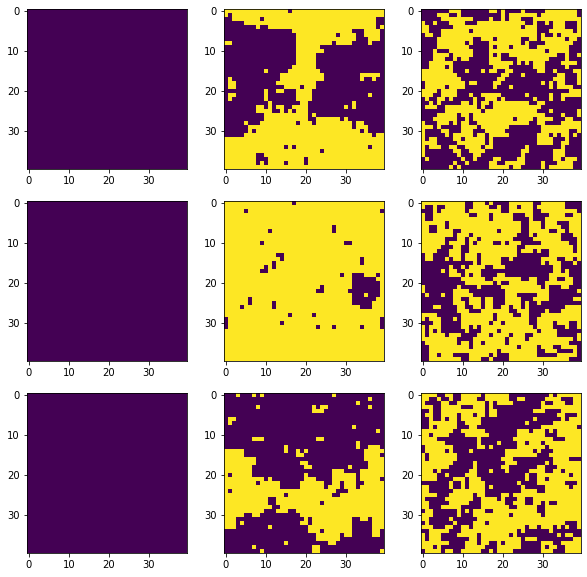

In [7]:
ising_sample_ordered = data_ordered[3,:].reshape(-1,40)
ising_sample_ordered_2 = data_ordered[37,:].reshape(-1,40)
ising_sample_ordered_3 = data_ordered[31,:].reshape(-1,40)

ising_sample_disordered = data_disordered[3,:].reshape(-1,40)
ising_sample_disordered_2 = data_disordered[37,:].reshape(-1,40)
ising_sample_disordered_3 = data_disordered[31,:].reshape(-1,40)

ising_sample_critical = data_critical[3,:].reshape(-1,40)
ising_sample_critical_2 = data_critical[37,:].reshape(-1,40)
ising_sample_critical_3 = data_critical[31,:].reshape(-1,40)



ising_visuals = np.array([ising_sample_ordered, ising_sample_critical, ising_sample_disordered,
                          ising_sample_ordered_2, ising_sample_critical_2, ising_sample_disordered_2,
                          ising_sample_ordered_3, ising_sample_critical_3, ising_sample_disordered_3]).reshape(3,3,40,40)


anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction',
                 va='center', ha='center')


gs = gridspec.GridSpec(3, 3,)
plt.figure(figsize=(10, 10))

for i in np.arange(3):
    for j in np.arange(3):
        ax = plt.subplot(gs[i,j])
        plt.imshow(ising_visuals[i,j])


<h3>Above we can see the ordered, critical and disordered samples resptectively.</h3>

<h2>Training a Deep Neural Network</h2>

<p>In this section we will create a deep neural network (DNN) architecture to try to make predictions and we will see how well it will do. </p>

<h3>We create our model in Keras.</h3>

In [8]:
model_dnn = models.Sequential() # Saying that the model is a sequential model
model_dnn.add(layers.Dense(75, activation='relu', input_shape=(1600,)))
model_dnn.add(layers.Dense(75, activation='relu'))
model_dnn.add(layers.Dense(4, activation='softmax')) 

<h4>Let's see the summary of the model.</h4>

In [9]:
model_dnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 75)                120075    
_________________________________________________________________
dense_2 (Dense)              (None, 75)                5700      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 304       
Total params: 126,079
Trainable params: 126,079
Non-trainable params: 0
_________________________________________________________________


<h3>Specify the optimizer and loss function measure.</h3>

<p>In this part it is worth pointing out that the learning rate needed to be manipulated by trial-error in order to avoid fitting issues.</p>

In [10]:
model_dnn.compile(optimizer=RMSprop(learning_rate=0.00001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

<h4>We convert our integer labels to unit vector form.</h4>

In [11]:
labels_train = to_categorical(labels_train) 
labels_test = to_categorical(labels_test)

<h3>We train our model for 20 epochs.</h3>

In [12]:
train_dnn = model_dnn.fit(data_train, labels_train, epochs=20,validation_data = (data_test,labels_test))

Train on 96000 samples, validate on 64000 samples
Epoch 1/20
96000/96000 [==============================] - 9s 95us/step - loss: 0.9311 - accuracy: 0.7063 - val_loss: 0.8534 - val_accuracy: 0.7377
Epoch 2/20
96000/96000 [==============================] - 7s 75us/step - loss: 0.8005 - accuracy: 0.7676 - val_loss: 0.7519 - val_accuracy: 0.7895
Epoch 3/20
96000/96000 [==============================] - 7s 74us/step - loss: 0.6949 - accuracy: 0.8042 - val_loss: 0.6452 - val_accuracy: 0.8137
Epoch 4/20
96000/96000 [==============================] - 7s 74us/step - loss: 0.5882 - accuracy: 0.8194 - val_loss: 0.5448 - val_accuracy: 0.8213
Epoch 5/20
96000/96000 [==============================] - 7s 74us/step - loss: 0.4981 - accuracy: 0.8322 - val_loss: 0.4700 - val_accuracy: 0.8394
Epoch 6/20
96000/96000 [==============================] - 7s 75us/step - loss: 0.4348 - accuracy: 0.8500 - val_loss: 0.4195 - val_accuracy: 0.8580
Epoch 7/20
96000/96000 [==============================] - 7s 75us/st

<h3>Let us take a look at the accuracy when we test it on the test set</h3>

In [13]:
train_dnn.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [14]:
test_loss, test_acc = model_dnn.evaluate(data_test,labels_test)

64000/64000 [==============================] - 1s 23us/step


In [15]:
print("The accuracy of the model on the test set is ",100*test_acc, "%")

The accuracy of the model on the test set is  92.03749895095825 %


<h3>We will record the predictions on the test set.</h3>

In [16]:
print("Generating predictions... ")
predictions_dnn = model_dnn.predict_classes(data_test)
print(predictions_dnn.shape)

Generating predictions... 
(64000,)


In [17]:
labels_test.shape

(64000, 4)

<h4>Remark: Predictions are going to be floating points since our outpur will be a softmax giving the possiblities. Therefore we will choose the highest possibility. We round them and get the best prediction this way.</h4>

In [18]:
rounded_labels_test =np.argmax(labels_test, axis=1)

In [19]:
rounded_labels_test.shape

(64000,)

<h3>We construct the confusion matrix from the predictions.</h3>

In [20]:
confusion_matrix_dnn = confusion_matrix(rounded_labels_test, predictions_dnn)

<h3>Below is a method to nicely visualize the confusion matrix.</h3>

In [21]:
def plot_confusion_matrix(confusion_matrix):
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Confusion Matrix ')
    plt.colorbar()
    plt.show()

<h3>We can see that our model predicts really well when we have disordered and ordered configurations. Critical region does not have as many data points. This is why it looks lighter in the matrix. </h3>

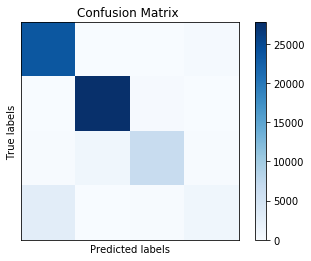

In [22]:
plot_confusion_matrix(confusion_matrix_dnn)

<h4>The values of the confusion matrix below shows that critical region predictions are not as good as non-critical region predictions.</h4>

In [23]:
confusion_matrix_dnn

array([[23558,     0,    41,   360],
       [    0, 27732,   247,     0],
       [  162,  1060,  6618,   195],
       [ 2839,     0,   192,   996]])

<h3>Now we define the plot functions for loss and accuracy so that we can compare the test and training datasets' results and conclude if our model is working well.</h3>

In [24]:
def loss_function(mdl):
    plt.plot(mdl.history['loss'])
    plt.plot(mdl.history['val_loss'])
    plt.title("Model Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'])
    plt.show()
def accuracy(mdl):
    plt.plot(mdl.history['accuracy'])
    plt.plot(mdl.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Test'])
    plt.show()

<h3>Below we can see that our model seems to be working well in terms of learning.</h3>
<p>However, in order to achieve this, I have manipulated the learning rate of the optimizer since previous results indicated that it was too high. This indication was done by observing the loss graph. Also I had to use the trial-error method to figure out a DNN architecture compatible for our problem.<p>
<p>On the other hand, our confusion matrix still indicates that critical region predictions are not as good. This may simply be because of the fact that we do not have as much data in the critical region as we do in the other regions.</p>

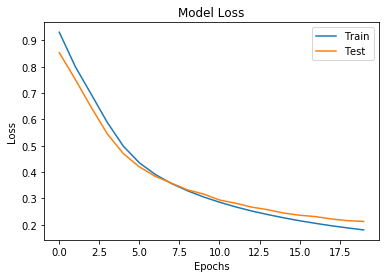

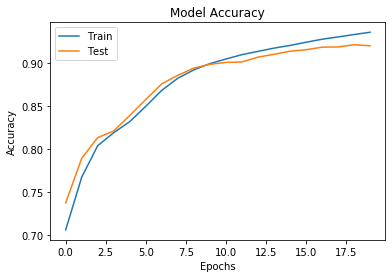

In [25]:
loss_function(train_dnn)
accuracy(train_dnn)

<h2>Training a Convolutional Neural Network (CNN)</h2>

<p>Since this is an image-like prediction problem, we can also approach it with the convolutional neural network model. We start building our CNN. CNN architecture is a little more complex than DNN. However it is worth noting that though it looks complicated, it is almost considered to be a typical structure for these types of problems.</p>

<h4>CNN's require the input to be in the following form:</h4>

In [26]:
data_train = data_train.reshape(data_train.shape[0],1,40,40)
data_test = data_test.reshape(data_test.shape[0],1,40,40)
input_shape = (1,40,40)

data_train, labels_train = shuffle(data_train, labels_train)
data_test, labels_test = shuffle(data_test, labels_test)

<h4>We create our CNN model.</h4>

In [27]:
# As usual we start by creating a sequential model
model_cnn = models.Sequential()

# We add the convolutional layer
model_cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
# The batch normalization: helping to generalize the training
model_cnn.add(BatchNormalization())
# Another convolutional layer
model_cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
# Batch normalization
model_cnn.add(BatchNormalization())
# Pooling for reducing overfitting
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same' ))
# We drop some neurons that will again help avoid overfitting
model_cnn.add(Dropout(0.25))

# We will add another series of the above with greater number of filters
model_cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same', strides=2))
model_cnn.add(Dropout(0.25))

# Flatten will convert our results to 1D type
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(1024, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.5))
# We have the final output layer
model_cnn.add(Dense(4, activation='softmax'))

<h3>We need the optimizer and other compile options selected.</h3>

In [28]:
model_cnn.compile(optimizer=RMSprop(learning_rate= 0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

<h3>At this point it is a complex architecture. Thankfully, Keras has a model summary method.</h3>

In [29]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 40, 32)         11552     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 40, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 40, 32)         9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 40, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 20, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 20, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 20, 64)        

<h3>Now we train the model. As this is a more complicated model than the DNN we trained, it may take awhile.</h3>

In [30]:
train_cnn = model_cnn.fit(data_train, labels_train,
          epochs=20,
          verbose=1,
          validation_data=(data_test, labels_test))

Train on 96000 samples, validate on 64000 samples
Epoch 1/20
96000/96000 [==============================] - 77s 802us/step - loss: 0.6345 - accuracy: 0.8032 - val_loss: 0.4139 - val_accuracy: 0.8306
Epoch 2/20
96000/96000 [==============================] - 73s 764us/step - loss: 0.4444 - accuracy: 0.8600 - val_loss: 0.4124 - val_accuracy: 0.8128
Epoch 3/20
96000/96000 [==============================] - 71s 738us/step - loss: 0.3779 - accuracy: 0.8759 - val_loss: 0.4169 - val_accuracy: 0.7994
Epoch 4/20
96000/96000 [==============================] - 73s 755us/step - loss: 0.3335 - accuracy: 0.8870 - val_loss: 0.3491 - val_accuracy: 0.8333
Epoch 5/20
96000/96000 [==============================] - 73s 759us/step - loss: 0.3031 - accuracy: 0.8944 - val_loss: 0.3420 - val_accuracy: 0.8406
Epoch 6/20
96000/96000 [==============================] - 73s 764us/step - loss: 0.2787 - accuracy: 0.9000 - val_loss: 0.3220 - val_accuracy: 0.8490
Epoch 7/20
96000/96000 [==============================] 

In [31]:
train_cnn.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

<h3>Now we can check how well the model is trained. Let us see the loss and accuracy vs. epochs.</h3>

In [32]:
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(data_test,labels_test)

64000/64000 [==============================] - 10s 150us/step


<h3>The model reaches around 95% accuracy each time I run it.</h3>

In [33]:
print("The accuracy of the model on the test set is ",100*test_acc_cnn, "%")

The accuracy of the model on the test set is  93.86093616485596 %


<h4>Commenting on the graphs below: we can say that the test is roughly shaped
    as if it is overlapping with the training results. In order to prevent fluctuations
    we can try to optimize the hyperparameters as we did for the DNN case. However,
    since CNN requires more computing power, the hyperparameter optimization would be 
    really hard on my laptop.</h4>

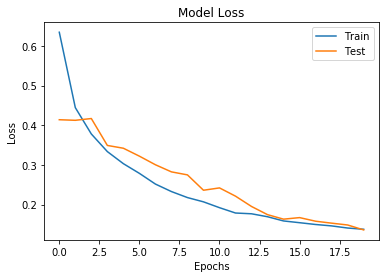

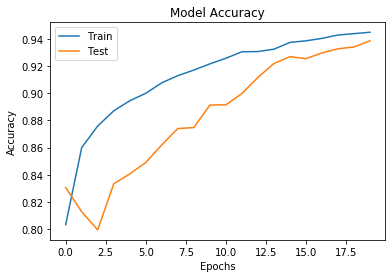

In [34]:
loss_function(train_cnn)
accuracy(train_cnn)

In [35]:
predictions_cnn = model_cnn.predict_classes(data_test)

In [36]:
rounded_labels_test =np.argmax(labels_test, axis=1)

In [37]:
confusion_matrix_cnn = confusion_matrix(rounded_labels_test, predictions_cnn)

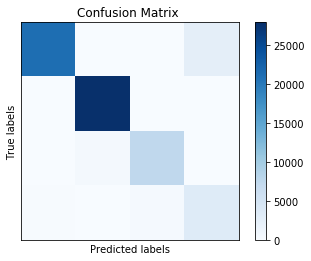

In [38]:
plot_confusion_matrix(confusion_matrix_cnn)

<h3>We can see above and below that this result is better than the DNN result not only in terms of pure accuracy rate but also in terms of how good the model worked for the critical region labels.</h3>

<p>Moreover, below values show that in the submatrix of bottom right quarter of the confusion matrix, which is the critical region part, we can see that between the critical regions there is not significant confusion. </p>

In [40]:
confusion_matrix_cnn

array([[21230,     0,     5,  2724],
       [    0, 27896,    83,     0],
       [    0,   538,  7483,    14],
       [  205,     0,   360,  3462]])

<h2>Final Remarks</h2>

<p>Beyond all these, with more computation power we can have better hyperparameter optimization and therefore get better results. Some of the problems we have is the number of critical region data. Our. confusion matrices show that we need more critical region data since the significant amount of errors are in the critical region. On the other hand we may encounter a limit of success when recognizing the critical region configurations. Because of the randomness of the Metropolis approach to the Ising model, although we can know we are approximately in the critical region and that this conclusion quantitatively can be made, we may not end up recognizing this region with image recognition techniques with a 95+% success rate. </p>

<p>Moreover, we can have the average magnetizations recorded along with the corresponding temperature. This way we can have a graph of magnetization vs. T in which we expect to see the critical temperature correctly around 2.26. However, as stated in the abstract of the course assignment, the main objective of this project is to classify different configurations of the Ising Model in 2D for a square lattice; therefore the critical temperature analysis is not present in this notebook. </p>